In [1]:
%run init_notebook.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import arviz as az

In [3]:
import pymc as pm

In [4]:
import arviz
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(100)

# functions

In [5]:
def get_arr_lagged(arr, lags):
    return np.concatenate([arr[i:-(lags+1-i)] for i in range(1, lags+1)], axis=1)

def get_filled_array(shape: tuple, vars: np.array):
    assert shape[1] == vars.shape[0], "Fill vars do not match fill array shape"
    arr = np.zeros(shape)
    for i in range(shape[1]):
        arr[:,i].fill(vars[i])
    return arr

def get_VAR(T, arr: np.array, lags, n_vars):
    arr_lag = get_arr_lagged(arr, lags)
    res = pm.math.sum(
        [
            A * arr_lag[i: i+1].ravel()
            for i in range(len(arr_lag))
        ],
        axis=-1)
    return res

def get_Fsmoothing(s_arr, gamma, c, use_tensor: bool = True):
    if use_tensor:
        return 1 / (1 + pm.math.exp(- gamma * (s_arr - c)))
    else:
        return 1 / (1 + np.exp(- gamma * (s_arr - c)))

# LSTR

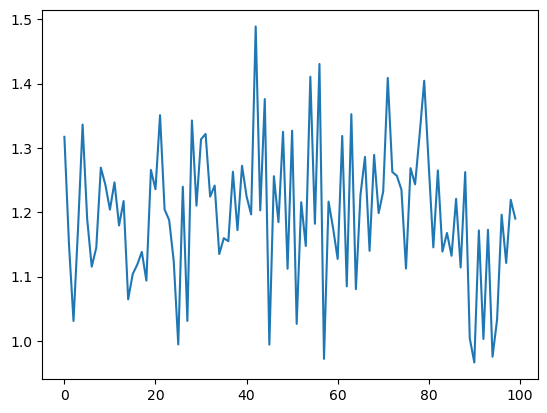

In [26]:
lstr_lags = 2
N = 120

alpha_true = 1
phis_true = norm(0, .4).rvs(lstr_lags)
psis_true = norm(0, .1).rvs(lstr_lags)
gamma_true = .5
c_true = .5
d_true = 1
assert d_true <= lstr_lags
sigma_true = .1

arr_lstr = np.zeros((N, 1))

for i in range(lstr_lags, N):
        arr_lstr[i] = alpha_true + \
                arr_lstr[i - lstr_lags: i].ravel() @ phis_true + \
                arr_lstr[i - lstr_lags: i].ravel() @ psis_true * (1 + np.exp(- gamma_true * (arr_lstr[i-d_true] - c_true))) + \
                norm(0, sigma_true).rvs()

arr_lstr = arr_lstr[20:]

plt.plot(arr_lstr)

Logistic Smooth Transistion Regression
$$ x_t = \alpha + \sum_{k=1}^{K} \phi_{k} x_{t-k} + \sum_{k=1}^{K} F_k \psi_{k} x_{t-k} +  \epsilon_t $$
where
$$ F_k = F(s_k, \gamma, c) = \frac{1}{1 - \exp\{ - \gamma (s_k - c)\}} $$

In [8]:
lstr_lags_max = 2
coords = {
    'n_lags': [*range(lstr_lags_max)],
    'mod_dim': [*range(2)],
}

# put data into tensors
pt_lstr = pt.as_tensor(arr_lstr[lstr_lags_max:]) # shape(len(data)-lags, 1)
arr_lstr_lags = get_arr_lagged(arr_lstr, lstr_lags_max)
pt_lstr_lag = pt.as_tensor(arr_lstr_lags) # shape(len(data) - lags, lags) - used for calculating coefs

## base line no endogeneous lags

In [11]:
with pm.Model(coords=coords) as LSTR:
    
    phi = pm.Normal('phi', mu=0, sigma=1, dims=('n_lags',))
    psi = pm.Normal('psi', mu=0, sigma=1, dims=('n_lags',))
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    gamma = pm.Normal('gamma', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', 1)

    x1 = pt.math.sum(phi * arr_lstr_lags, axis=1)
    x2 = pt.math.sum(psi * arr_lstr_lags, axis=1) * get_Fsmoothing(arr_lstr_lags[:,1], gamma, c)
    mu = alpha + pt.math.sum( pt.stack([x1, x2], axis=1), axis=1)

    vals = pm.Normal('vals', mu=mu, sigma=sigma, observed=arr_lstr[lstr_lags_max:])

    lstr_data = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, psi, alpha, gamma, c, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 921 seconds.


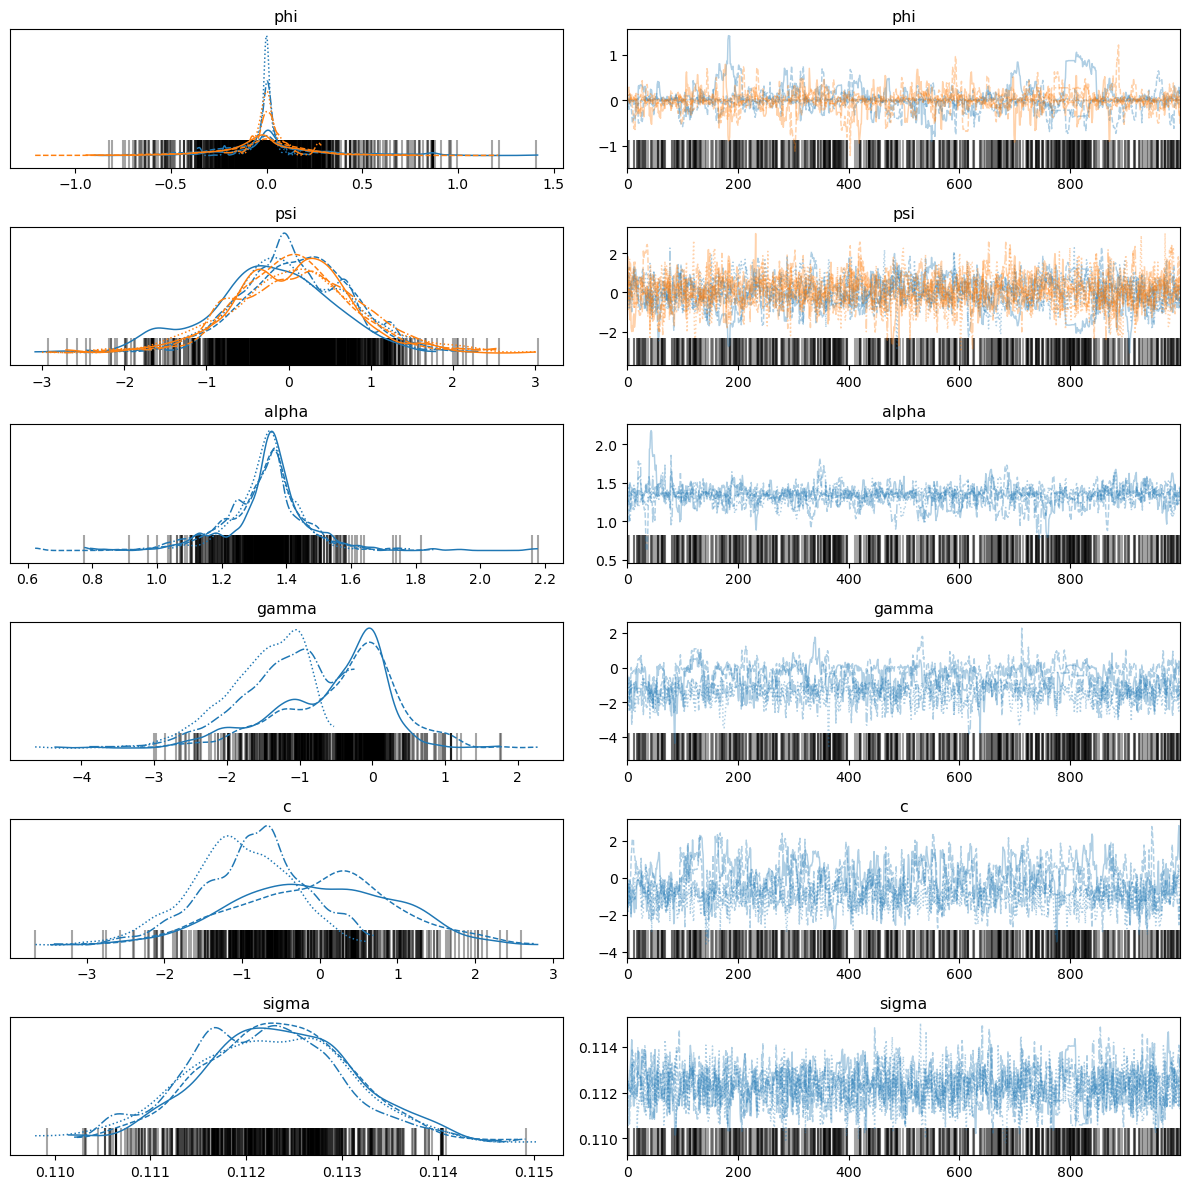

In [12]:
az.plot_trace(lstr_data)
plt.tight_layout();

In [20]:
from itertools import chain

['phi_1', 'phi_2', 'psi_1', 'psi_2', 'alpha', 'gamma', 'c', 'sigma']

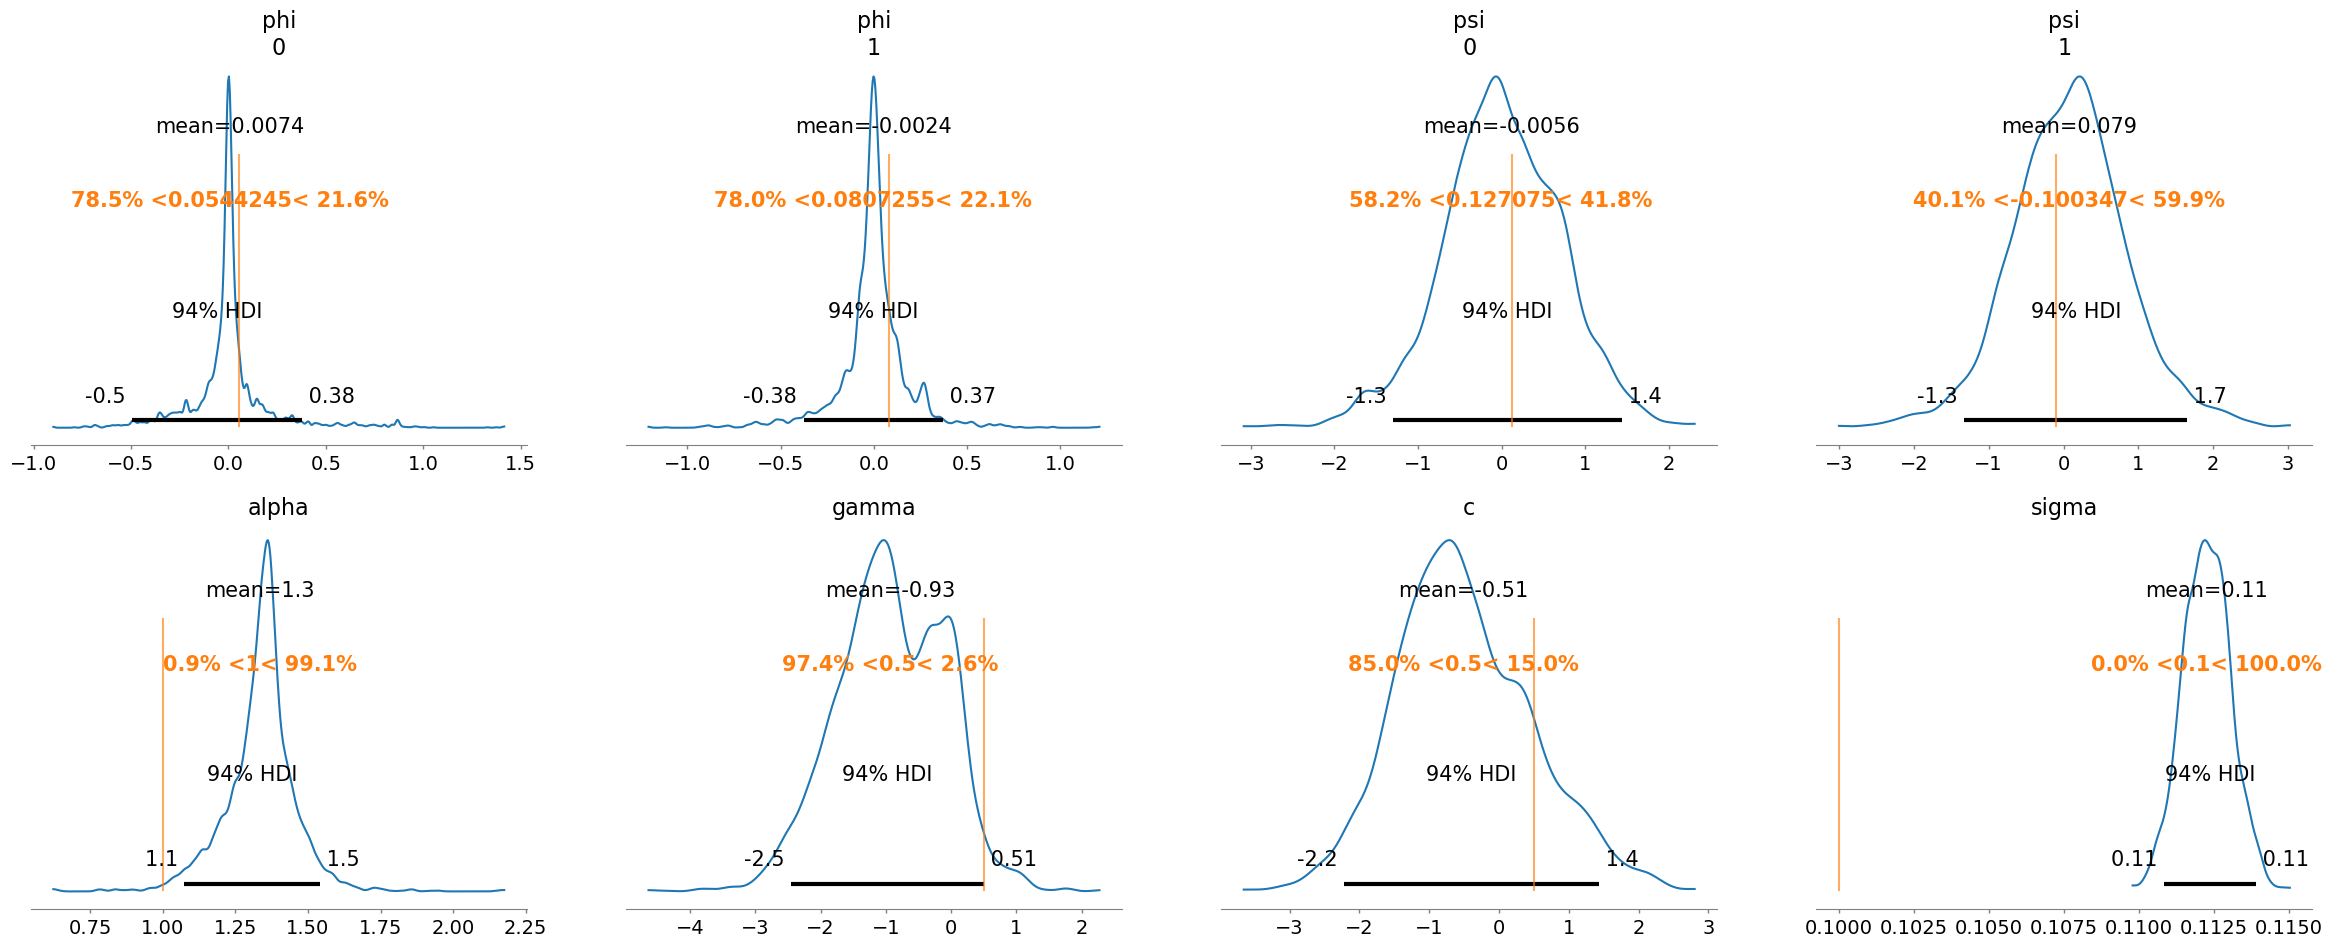

In [27]:
az.plot_posterior(lstr_data, 
                  # var_names=[*chain(*[*[[f'{coef}_{i}' for i in range(1, lstr_lags+1)] for coef in ['phi', 'psi']],  ['alpha', 'gamma', 'c', 'sigma']])],
                  var_names=['phi', 'psi', 'alpha', 'gamma', 'c', 'sigma'],
                  ref_val=[*phis_true, *psis_true, alpha_true, gamma_true, c_true, sigma_true]);

In [28]:
rand_int = lambda : np.random.randint(0, lstr_data.sample_stats.chain.values[-1] +1)

In [29]:
sample = np.array(
    [
    
        
    arr_lstr_lags @ lstr_data.posterior.phi[rand_int(), i].values + \
    arr_lstr_lags @ lstr_data.posterior.psi[rand_int(), i].values * \
    get_Fsmoothing(arr_lstr_lags[:,1], 
                   lstr_data.posterior.gamma[rand_int(), i].values,
                   lstr_data.posterior.c[rand_int(), i].values,
                   use_tensor=False)
    for i in range(0, 1_000)
    ]
)

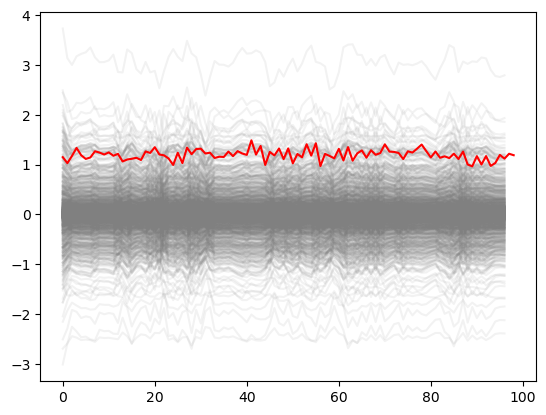

In [30]:
plt.plot(sample.transpose(), alpha=.1, color='grey');
plt.plot(arr_lstr[lstr_lags_max-1:], color='red');

## endogenous lags k

In [34]:
pt_lstr_lag

TensorConstant{[[1.771971..26271554]]}

In [35]:
with pm.Model(coords=coords) as LSTRE:
    k_lag = pm.DiscreteUniform('k_lag', 1, len(coords['n_lags']))
    k = pt.max((1, k_lag))
    k = pt.min((k, len(coords['n_lags'])))
    
    # pt_data = pm.ConstantData("pt_data", value=pt_lstr_lag)
    _pt_data = pm.Deterministic("pt_data", pt_lstr_lag[:, :k])

    phi = pm.Normal('phi', mu=0, sigma=1, dims=('n_lags',))
    psi = pm.Normal('psi', mu=0, sigma=1, dims=('n_lags',))
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    gamma = pm.Normal('gamma', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)

    x1 = pt.math.sum(phi * _pt_data, axis=1)
    x2 = pt.math.sum(psi * _pt_data, axis=1) * get_Fsmoothing(_pt_data[:,pt.as_tensor(1)], gamma, c)
    mu = alpha + pt.math.sum( pt.stack([x1, x2], axis=1), axis=1)

    vals = pm.Normal('vals', mu=mu, sigma=1, observed=pt_lstr)

    lstrE_data = pm.sample()

IndexError: index out of bounds
Apply node that caused the error: Subtensor{int64:int64:int8, int64}(TensorConstant{[[1.771971..26271554]]}, ScalarConstant{0}, ScalarConstant{97}, ScalarConstant{1}, ScalarFromTensor.0)
Toposort index: 29
Inputs types: [TensorType(float64, (97, 2)), ScalarType(int64), ScalarType(int64), ScalarType(int8), ScalarType(int64)]
Inputs shapes: [(97, 2), (), (), (), ()]
Inputs strides: [(16, 8), (), (), (), ()]
Inputs values: ['not shown', 0, 97, 1, 3]
Outputs clients: [[InplaceDimShuffle{0,x}(Subtensor{int64:int64:int8, int64}.0)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_15588\2430347692.py", line 21, in <module>
    lstrE_data = pm.sample()
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\pymc\sampling\mcmc.py", line 486, in sample
    model.check_start_vals(ip)
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\pymc\model.py", line 1765, in check_start_vals
    initial_eval = self.point_logps(point=elem)
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\pymc\model.py", line 1794, in point_logps
    factor_logps_fn = [at.sum(factor) for factor in self.logp(factors, sum=False)]
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\pymc\model.py", line 757, in logp
    rv_logps = _joint_logp(
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\pymc\distributions\logprob.py", line 148, in _joint_logp
    temp_logp_terms = factorized_joint_logprob(
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\pymc\logprob\joint_logprob.py", line 119, in factorized_joint_logprob
    fgraph, rv_values, _ = construct_ir_fgraph(rv_values, ir_rewriter=ir_rewriter)
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\pymc\logprob\rewriting.py", line 346, in construct_ir_fgraph
    ir_rewriter.rewrite(fgraph)
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
    return super().run_cell(*args, **kwargs)
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
    result = self._run_cell(
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
    result = runner(coro)
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_15588\2430347692.py", line 16, in <module>
    x2 = pt.math.sum(psi * _pt_data, axis=1) * get_Fsmoothing(_pt_data[:,pt.as_tensor(1)], gamma, c)
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
    return super().run_cell(*args, **kwargs)
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
    result = self._run_cell(
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
    result = runner(coro)
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "C:\Users\LukasGrahl\miniforge3\envs\mamba_env_m2FE\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_15588\2430347692.py", line 7, in <module>
    _pt_data = pm.Deterministic("pt_data", pt_lstr_lag[:, :k])

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

# VAR

In [ ]:
n_lags = 2
n_vars = 2
N = 220
sigma = .5
alpha = np.array(list([.5] * n_vars))

# fake data
A = np.zeros((n_vars, n_lags * n_vars))
for i in range(0, n_vars):
    A[i] = norm(0, .2).rvs((n_lags * n_vars))

arr = np.zeros((N + 20, n_vars))
for i in range(n_lags, N + 20):
    arr[i] = alpha + A @ arr[i - n_lags: i].ravel() + norm(0, sigma).rvs(n_vars)
    
arr = arr[20:]
plt.plot(arr)

In [ ]:
coords = {
    'n_lags': [*range(0, n_lags)],
    'n_vars': [*range(0, n_vars)],
    'n_var_lags': [*range(0, n_lags*n_vars)],
    'time': [*range(n_lags, N)],
}

In [181]:
with pm.Model(coords=coords) as VAR:
    Theta = pm.Normal('Theta', mu=0, sigma=1, dims=('n_vars', 'n_var_lags'))
    # sigma = pm.HalfNormal('sigma', 1, dims=('n_vars',))
    alpha = pm.Normal('alpha', mu=0, sigma=1, dims=('n_vars',))

    sd_dist = pm.Exponential.dist(1.0, size=len(coords['n_vars']))
    packed_chol = pm.LKJCholeskyCov('sigma_chol', eta=1, n=len(coords['n_vars']), sd_dist=sd_dist, compute_corr=False)
    chol = pm.expand_packed_triangular(n=len(coords['n_vars']), packed=packed_chol, lower=True)

    mu = alpha + get_VAR(Theta, arr, len(coords['n_lags']), len(coords['n_vars']))

    # likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=arr[n_lags:], dims=('time', 'n_vars',))
    vals = pm.MvNormal('vals', mu=np.zeros(len(coords['n_vars'])), chol=chol, dims=('time', 'n_vars',), observed=arr[n_lags:])

    idata = pm.sample() #(draws=100, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Theta, alpha, sigma_chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


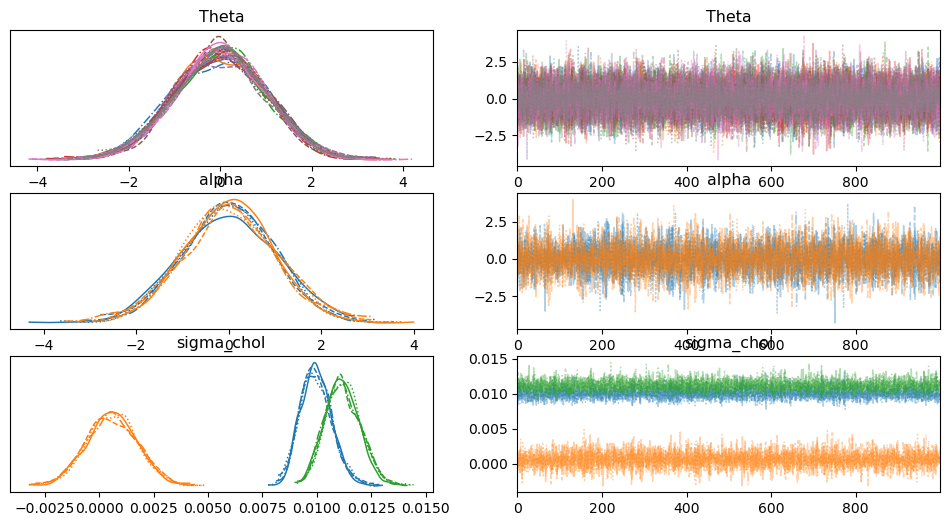

In [182]:
az.plot_trace(idata);

## plot posterior outcome

In [ ]:
arr_lagged = get_arr_lagged(arr, n_lags)
samples = [
    [
        idata.posterior.Theta[np.random.randint(0, len(idata.sample_stats.chain)), z].values @ arr_lagged[i] 
        for i in range(arr_lagged.shape[0])
    ]
    for z in np.random.randint(0, len(idata.sample_stats.draw), 100)
]

samples = np.array(samples)

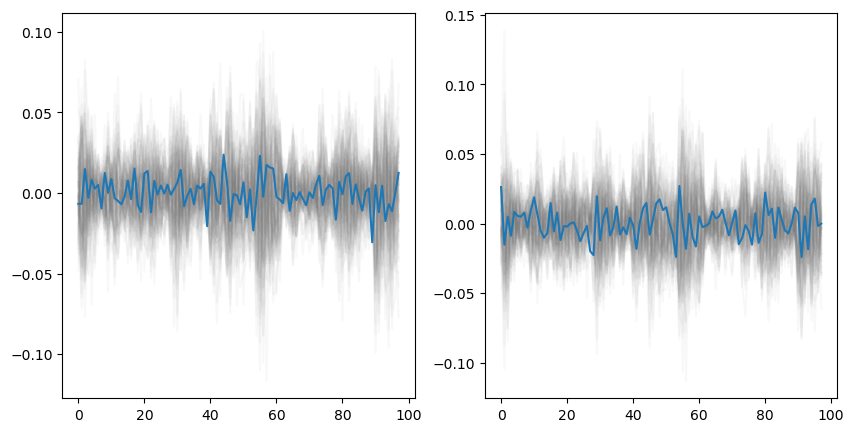

In [186]:
cols = 2
rows = int(np.ceil(n_vars / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5 * rows))
for idx, ax in enumerate(axes.ravel()):
    ax.plot(samples[:, :, idx].transpose(), color='grey', alpha=.05);
    ax.plot(arr[n_lags:, idx])